In [1]:
import pandas as pd
import os 
import glob 
import math 
import re
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [2]:
# methods to plot objects in arenas

def plot_arena(ax):
    # arena: arena.world 
    ax.add_patch(patches.Rectangle((-5,-5), 1, 10, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-5), 1, 10, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-5), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,4), 10, 1, edgecolor='lightgrey', facecolor='none'))

    
def plot_arena_large(ax):
    # arena: arena_large.world
    ax.add_patch(patches.Rectangle((-10,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-10), 20, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,9), 20, 1, edgecolor='lightgrey', facecolor='none'))

    
def plot_two_rooms(ax): 
    # arena: two_rooms.world
    ax.add_patch(patches.Rectangle((-10,-8), 1, 16, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-8), 1, 16, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,2), 1, 6, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,-8), 1, 6, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,7), 20, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-8), 20, 1, edgecolor='lightgrey', facecolor='none'))

def plot_arena_corners(ax):
    # arena: arena_corners.world 
    ax.add_patch(patches.Rectangle((-5,-6), 1, 12, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-6), 1, 12, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-6), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,5), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,-3), 1, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((0,4), 1, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4, 1.5), 1, 1.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((3, 0), 1, 2, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2, -5), 2, 2, edgecolor='lightgrey', facecolor='none'))

def plot_arena_walls(ax):
    # arena: arena_walls.world
    ax.add_patch(patches.Rectangle((-7,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-7), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,6), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((0,2), 0.25, 4, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,-0.75), 4, 0.25, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,-4), 0.25, 3, edgecolor='lightgrey', facecolor='none'))


In [36]:
# method to create visualization 

def create_plot(objects, robots, lidar, arena, r, robot, ax):
    # create plot with robots, obstacles and lidar data 
    
    #arena = "arena-walls"
    lidar_obj, lidar_kin = lidar
    
    ax.set_title(str(robot))
        
    if arena == 'arena':
        plot_arena(ax)
    elif arena == 'arena-large':
        plot_arena_large(ax)
    elif arena == "two-rooms":
        plot_two_rooms(ax) 
    elif arena == "arena-corners":
        plot_arena_corners(ax)
    elif arena == "arena-walls":
        plot_arena_walls(ax)


    ax.scatter(*objects.T, facecolors='blue', marker='+') # objects except ground plane 
    ax.scatter(*robots.T, facecolors='none', edgecolors='orange') # robots 
    ax.scatter(*r.T, facecolors='green', edgecolors='green', marker='*') # robots 
    ax.scatter(*lidar_obj.T, s=0.5, color='blue') # lidar objects
    ax.scatter(*lidar_kin.T, s=0.5, color='orange') # lidar kins

In [25]:
# data frame processing 

def get_positions(df, idx):        
    # get object and robot positions from data frame 
    
    objects = [] 
    robots = [] 
    r = []
    angle = 0 
    
    # get object names  
    names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')] 

    string = df['poses'][idx]

    for i in range(0, len(names)):
        # get position 
        start = string.find('Point')
        stop = string[start:].find(')')
        pose = string[start+6:start+stop].split(', ')
        
        # get yaw angle (rotation around x-axis )
        string = string[start+6:]
        start = string.find('Quaternion')
        stop = string[start:].find(')')
        orientation = string[start+11:start+stop].split(', ')
        
        if names[i] == df['robot'][idx]: 
            r = [float(pose[0][2:]), float(pose[1][2:])]
            angle = calculate_yaw(orientation)            
        elif names[i][:5] == "robot" :
            robots.append([float(pose[0][2:]), float(pose[1][2:])])             
        elif names[i] != "ground_plane": 
            objects.append([float(pose[0][2:]), float(pose[1][2:])])
    
    return np.array(objects), np.array(robots), np.array(r), angle 


def calculate_yaw(orientation):
    # calculate yaw angle (around x-axis)
    
    q_x = float(orientation[0][2:])
    q_y = float(orientation[1][2:])
    q_z = float(orientation[2][2:])
    q_w = float(orientation[3][2:])

    siny_cosp = 2 * (q_w * q_z + q_x * q_y)
    cosy_cosp = 1 - 2 * (q_y * q_y + q_z * q_z)

    return np.arctan2(siny_cosp, cosy_cosp)

    
def transform_lidar(df, r, angle, idx):  
    # transform lidar data from angle - distance to point 
    
    # get lidar data 
    ld = [float(el) for el in df['scan'][idx].split('ranges=[')[1].split('],')[0].split(',')]
        
    # transform lidar data to x, y positions 
        
    lidar = np.empty(shape=(360,2))

    for i in range(0, 360): 
        if not math.isinf(ld[i]):
            lidar[i][0] = ld[i] * math.cos(angle + np.deg2rad(i)) + r[0]
            lidar[i][1] = ld[i] * math.sin(angle + np.deg2rad(i)) + r[1]
        else: 
            lidar[i][0] = float('inf')
            lidar[i][1] = float('inf')
    
    return lidar

In [37]:
# determine if lidar points belong to an object or kin based on gt position data

def detect_kin(robots, lidar):
    sel = np.zeros(len(lidar))
    for kin in range(len(robots)):
        robot = robots[kin]
        sel_robot = ((lidar - robot) ** 2).sum(-1) < 0.15 ** 2
        sel[sel_robot] = 1
    sel = sel.astype(bool)
    return lidar[~sel], lidar[sel]

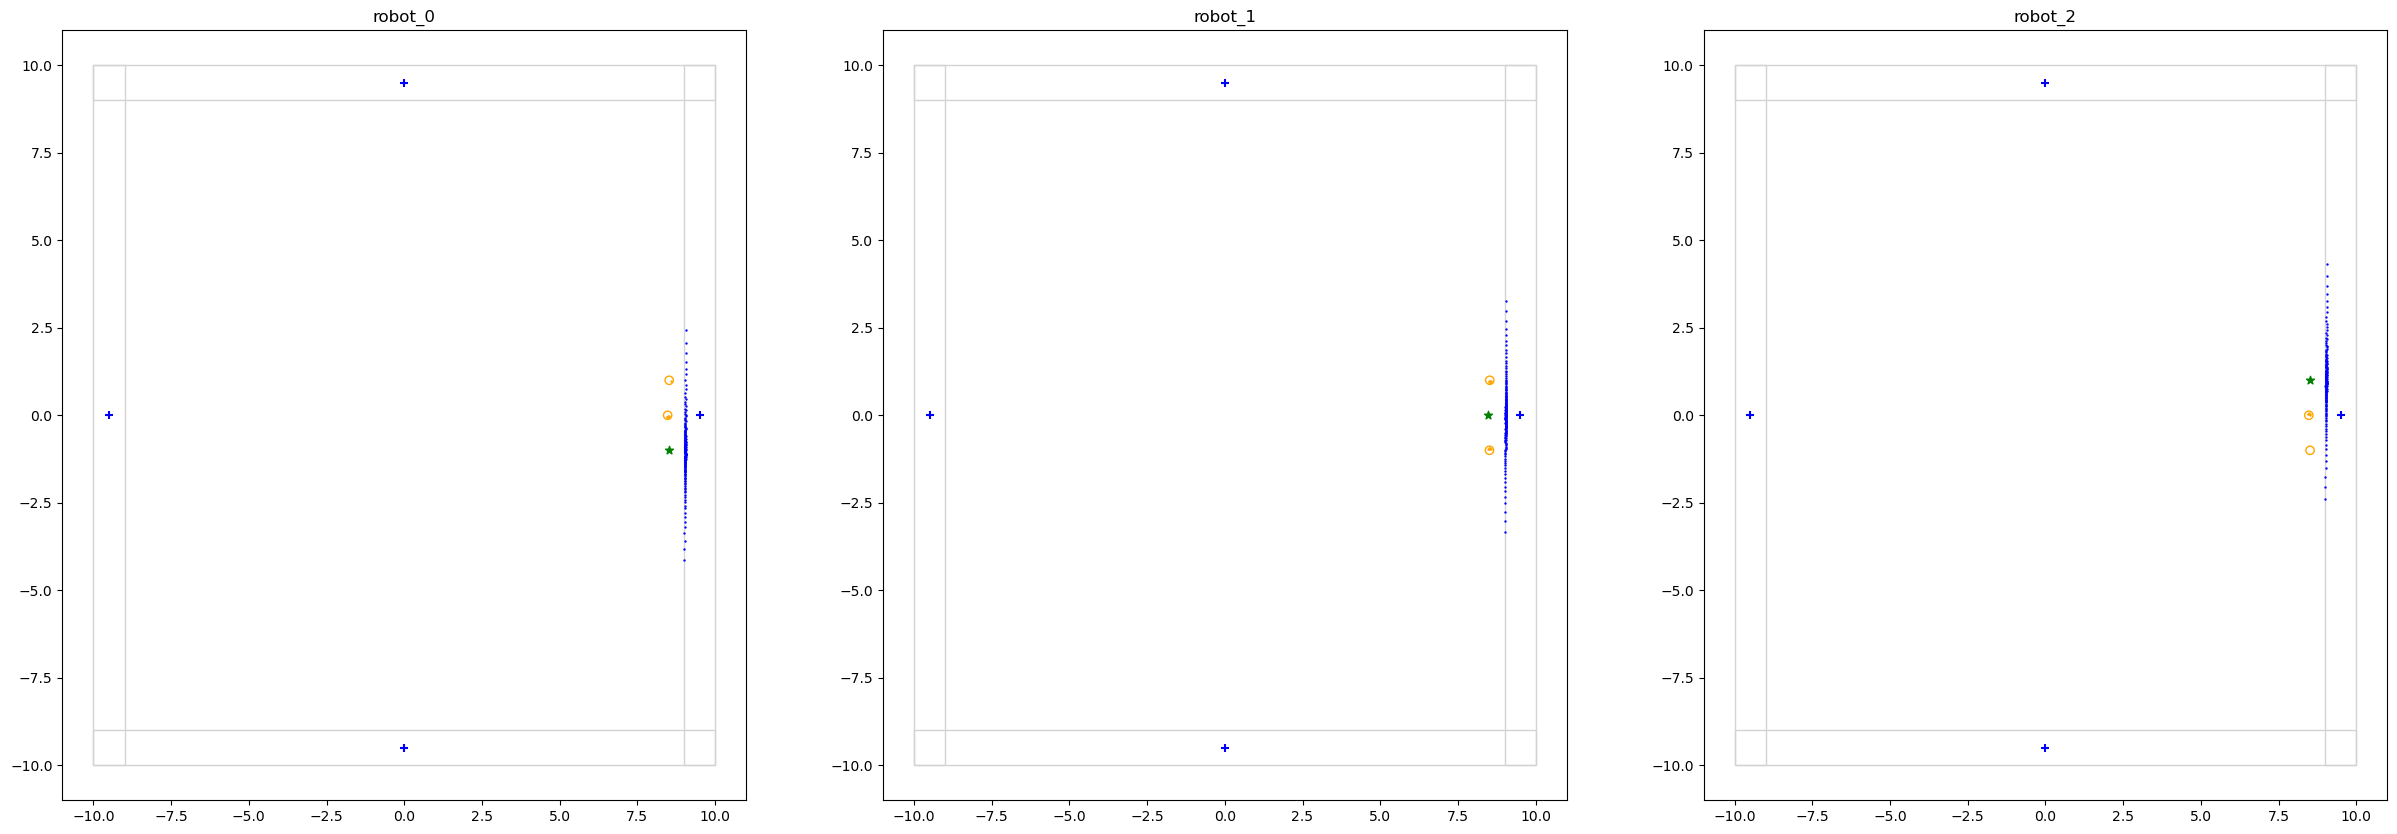

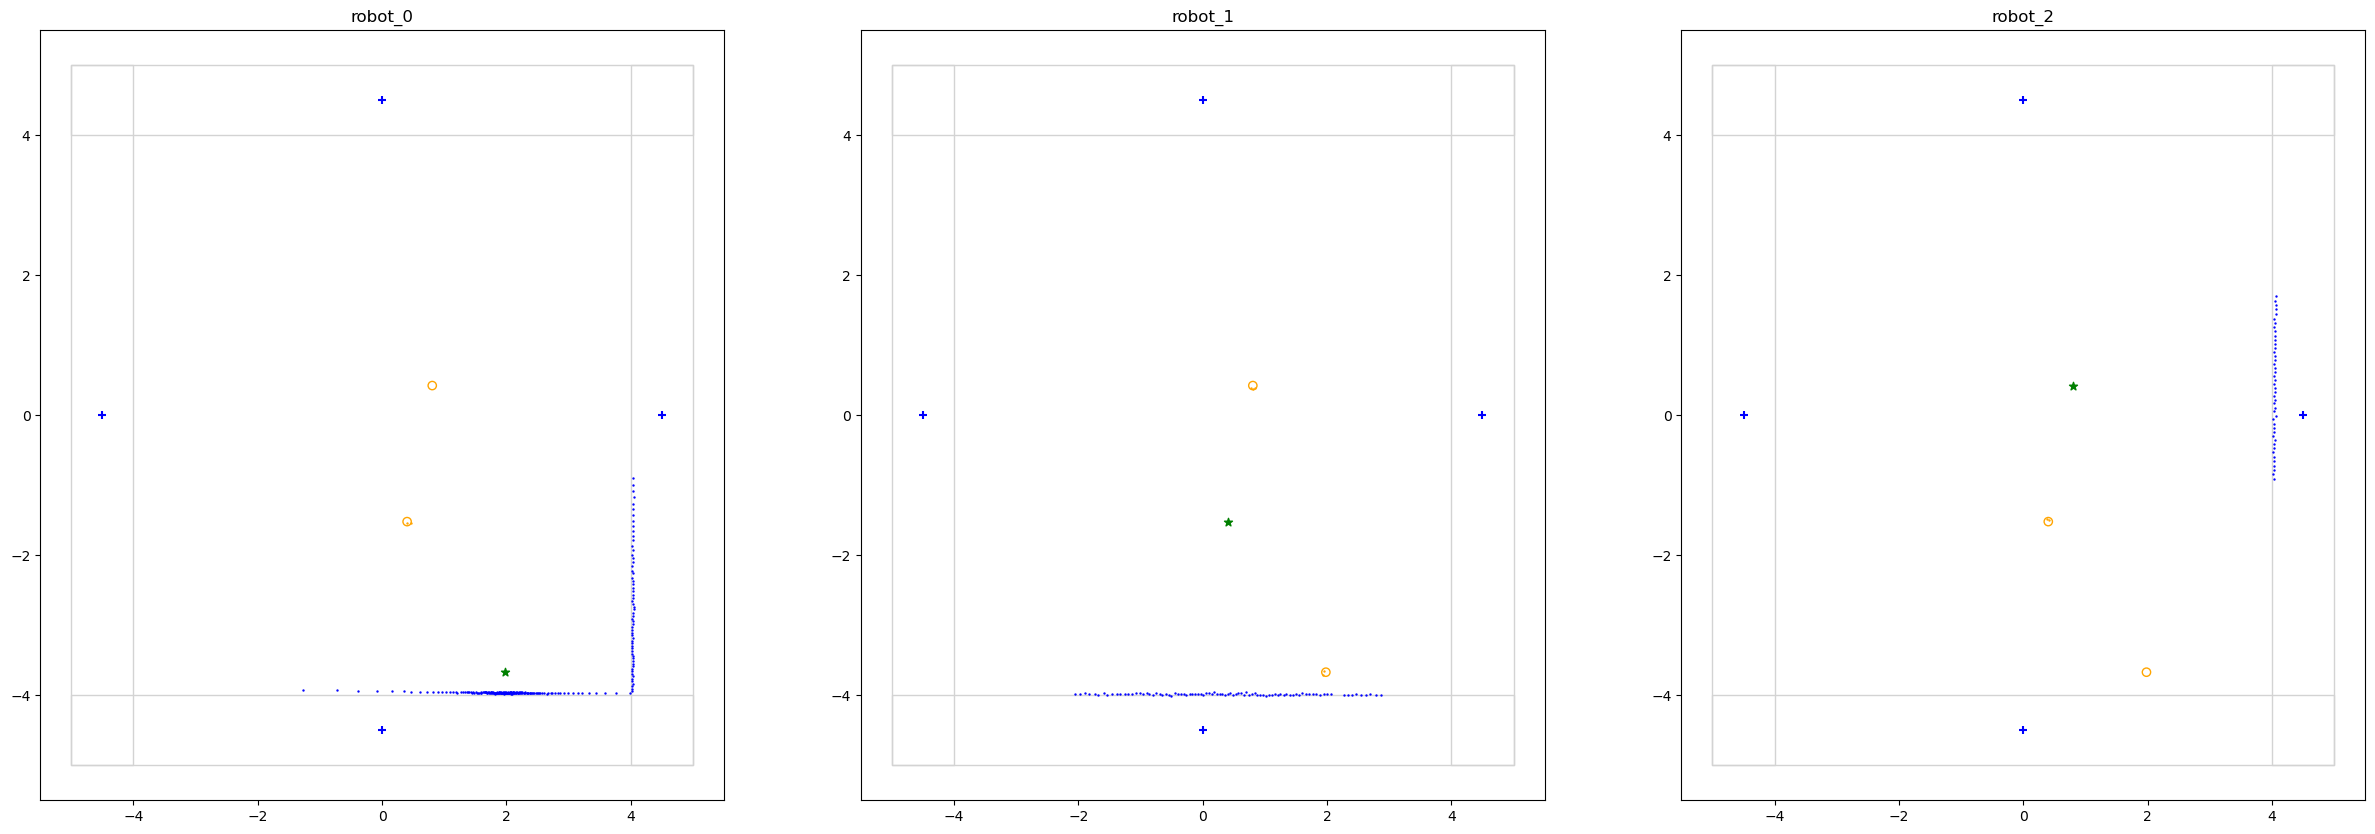

In [52]:
# main function 

def main(idx=0): 
    # get folders with rosbags / lidar data  
    subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:5] == 'arena']

    for subfolder in subfolders: 
        files = glob.glob(subfolder+'/*.csv')
        arena = subfolder.split('_')[0]
        
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))

        for rob, f in enumerate(files):  
            
            df = pd.read_csv(f)

            # get robot and object positions 
            objects, robots, r, angle = get_positions(df, idx) 
            
            # transform lidar scans to points 
            lidar = transform_lidar(df, r, angle, idx)
            
            # determine if object or kin
            lidar = detect_kin(robots, lidar)
            
            # create plot 
            create_plot(objects, robots, lidar, arena, r, df['robot'][idx], axes[rob])
        
        
if __name__ == "__main__":

    main(idx=40)

In [ ]:
# save all plots to create a gif

# get folders with rosbags / lidar data  
subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:5] == 'arena']

print(subfolders)

for subfolder in subfolders: 
    files = glob.glob(subfolder+'/*.csv')
    arena = subfolder.split('_')[0]
    
    
    dfs = [pd.read_csv(f) for f in files]
    
    for idx in range(len(dfs[0]['poses'])):
        
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))
        
        for rob, df in enumerate(dfs):  
        
            # get robot and object positions 
            objects, robots, r, angle = get_positions(df, idx) 

            # transform lidar scans to points 
            lidar = transform_lidar(df, r, angle, idx)

            # determine if object or kin
            lidar = detect_kin(robots, lidar)

            # create plot 
            create_plot(objects, robots, lidar, arena, r, df['robot'][idx], axes[rob])
        plt.savefig("./figures/gt_figs/" + re.sub('\\\\.*$', '', files[0]) + "_%d.png" % (idx,))
        plt.close()

['arena-large_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_11-55-21', 'arena_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_11-53-43']


In [51]:
subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:1] != '.' and f.name[:5] == 'arena']
subfolders

['arena-large_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_11-55-21',
 'arena_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_11-53-43']